# Wine: How Does Characteristics Compare to Chemical Breakdown When Predicting The Rating Of a Wine?

# Part 1: Wine Reviews Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from collections import Counter

In [2]:
data = pd.read_csv('winemag-data-130k-v2.csv')
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Data Preprocessing
In order to maximize the data first I dropped the taster_twitter_handle since it is repeated data. Then since I couldn't work with the title and discription columns of the wine but I thought that it would be interesting to see if the number of words in the wine's name or description was influencial.
    
 One issue I found was that many of the designation lables weren't the same. For example some would have extra dashes or words would be plural while some would be singular, there would be an extra connecting word, or it would be the same name but in another language. So to help fix his problem I made the column lowercase and removing any rows where the designation lable didn't appear more than 10 times. This went for several other columns.

As for any missing data if the data was numeric I dropped the row and if it was catagorical I replaces it with a 'None" string. Though I could have done more to help preserve the size of the dataframe I think that redicing it is the better choice since the Wine Quality dataframe only has about 6500 rows. If the wine reviews dataframe is significantly bigger then the model could perform better just on the principle that it has more data to train on

In [3]:
# Drop columns
data = data.drop(labels=['taster_twitter_handle'], axis = 1)

# Delete rows where columns have a small number of nans
data = data.drop([86909], axis = 0)
data = data[pd.notnull(data['country'])]
# replace nan values with none
data = data.dropna(subset = ['price']) #dropped all rows that didn't include price 
    # MAYBE GO BACK CAND CHANGE THIS
data = data.fillna(value = 'None')
# This reduces the data frok 130,000 to 120,915

# Get the length of each wine name
title_length = [len(x.split()) for x in list(data['title'])]
data['title_length'] = title_length
data = data.drop(labels=['title'], axis = 1)

# Get the length of each wine description
description_length = [len(x.split()) for x in list(data['description'])]
data['description_length'] = description_length
data = data.drop(labels=['description'], axis = 1)

# adjust points so that they are on the same scale as the other dataset
data.points.div(10)

data['designation'] = data['designation'].str.lower()


In [4]:
# Many of the wines are very unique so I removed the wines that only appeared a handfull of times
data = data[data['designation'].isin([k for k, v in Counter(list(data['designation'])).items() if v > 10])]
data = data[data['country'].isin([k for k, v in Counter(list(data['country'])).items() if v > 89])]
data = data[data['variety'].isin([k for k, v in Counter(list(data['variety'])).items() if v > 10])]
data = data[data['winery'].isin([k for k, v in Counter(list(data['winery'])).items() if v > 10])]
data.head()

,Unnamed: 0,country,designation,points,price,province,region_1,region_2,taster_name,variety,winery,title_length,description_length
2,2,US,none,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Pinot Gris,Rainstorm,6,28
7,7,France,none,87,24.0,Alsace,Alsace,None,Roger Voss,Gewürztraminer,Trimbach,4,21
9,9,France,les natures,87,27.0,Alsace,Alsace,None,Roger Voss,Pinot Gris,Jean-Baptiste Adam,8,30
10,10,US,mountain cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,Cabernet Sauvignon,Kirkland Signature,9,36
11,11,France,none,87,30.0,Alsace,Alsace,None,Roger Voss,Gewürztraminer,Leon Beyer,5,32


In [5]:
# Create another variable if the wine is from the top 10 countries known for wine
top10 = []
notTop10 = []
for i in list(data['country'].isin(['France', 'Italy','Spain','US','Argentina','Australia','Germany','South Afrca','Chile','Portugal'])):
    if i:
        top10.append(1)
        notTop10.append(0)
    else:
        top10.append(0)
        notTop10.append(1)
top10        
data['top10_Country'] = top10
data['notTop10_Country'] = notTop10

In [6]:
#Split the data into training and test sets
features = list(data)
features.remove('Unnamed: 0')
features.remove('points')


# Create training and test splits
data_x = data[features]
data_y = data['points']

In [7]:
# One-Hot Encode Variables
data_x = pd.get_dummies(data_x, columns=['country','designation', 'province', 'region_1','region_2','taster_name','variety','winery'])
data_x.head() #(26614 rows, 2655 columns)


,price,title_length,description_length,top10_Country,notTop10_Country,country_Argentina,country_Australia,country_Austria,country_Canada,country_Chile,...,winery_Zaca Mesa,winery_Zantho,winery_Zenato,winery_Zina Hyde Cunningham,winery_Zolo,winery_Zorzal,winery_Zotovich Cellars,winery_Zuccardi,winery_oops,winery_àMaurice
2,14.0,6,28,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,24.0,4,21,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,27.0,8,30,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,19.0,9,36,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,30.0,5,32,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# To try to better understand the data I tested the correlation between the points and the other variables which 
#showed to have insignificant correlation
correlated_values = []
for i in list(data_x):
    if data_x[i].corr(data_y) > .1 or data_x[i].corr(data_y) < -.1:
        print(i,'and points have a correlation of', data_x[i].corr(data_y))
        correlated_values.append(i)

price and points have a correlation of 0.45111736218256504
title_length and points have a correlation of 0.16559143968374196
description_length and points have a correlation of 0.5282095837360421
country_Argentina and points have a correlation of -0.13629617149124115
country_Chile and points have a correlation of -0.2018660991979389
designation_none and points have a correlation of -0.13639135297731977
province_Mendoza Province and points have a correlation of -0.13026934455593983
region_1_California and points have a correlation of -0.1616470226311091
region_1_Mendoza and points have a correlation of -0.11652650519756004
region_1_None and points have a correlation of -0.10989429989644192
region_2_California Other and points have a correlation of -0.1629026828667652
taster_name_Anne Krebiehl MW and points have a correlation of 0.11680126614511858
taster_name_Matt Kettmann and points have a correlation of 0.1416627517673968
taster_name_Michael Schachner and points have a correlation of 

In [9]:
#Split the data into training and Final test sets
x_train, x_test1, y_train, y_test1 = train_test_split(data_x, data_y, test_size = 0.2, random_state = 4)

#Split the data again to help build the model
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 4)

# Data Modeling
To model this data I tried SVM, Random Forest, Naieve Bayse, and liner regression.

## SVM
Since the data has so many columns I thought that trying a SVM would be a good start in trying to model the data. However, the model was terribly inaccurate. When using all of the vaiables no value of c could make the accuracy greater than 20%. This only improved slightly when variables that were less correlated were removed making the accuraccy slightly greater than 20% for all c.

In [8]:
# Create model and fit using all variables
mod = svm.SVC(C=1.0)
mod.fit(x_train, y_train)

# Make predictions
y_hat = mod.predict(x_test)
print('--------- Evaluating model: C= =' + str(1.0) + '---------')
print('Accuracy: ' + str(accuracy_score(y_hat, y_test)))
print('Avg. F1 (Micro): ' + str(f1_score(y_hat, y_test, average='micro')))
print('Avg. F1 (Macro): ' + str(f1_score(y_hat, y_test, average='macro')))
print('Avg. F1 (Weighted): ' + str(f1_score(y_hat, y_test, average='weighted')))
print(classification_report(y_test, y_hat))
#print('Confusion Matrix: \n' + str(confusion_matrix(y_hat, y_test)))

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


--------- Evaluating model: C= =1.0---------
Accuracy: 0.18614130434782608
Avg. F1 (Micro): 0.18614130434782608
Avg. F1 (Macro): 0.07771317737913737
Avg. F1 (Weighted): 0.2551045466642685
              precision    recall  f1-score   support

          80       0.00      0.00      0.00        13
          81       0.00      0.00      0.00        25
          82       0.00      0.00      0.00        76
          83       0.00      0.00      0.00        88
          84       0.00      0.00      0.00       267
          85       0.00      0.00      0.00       368
          86       0.00      0.00      0.00       474
          87       0.19      0.65      0.30       651
          88       0.19      0.27      0.22       631
          89       0.00      0.00      0.00       402
          90       0.16      0.30      0.21       539
          91       0.00      0.00      0.00       367
          92       0.19      0.22      0.20       238
          93       0.33      0.01      0.03       149
 

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
# Create model and fit for different values of c using only correlated vairables.

cs = [0.2, 0.5 ,1.0 ,2.0 ,5.0, 6.0, 10,0]
for c in cs:
# Create model and fit
    mod = svm.SVC(C=c)
    mod.fit(x_train[correlated_values], y_train)

    # Make predictions
    y_hat = mod.predict(x_test[correlated_values])
    print('--------- Evaluating model: C= =' + str(c) + '---------')
    print('Accuracy: ' + str(accuracy_score(y_hat, y_test)))
    print('Avg. F1 (Micro): ' + str(f1_score(y_hat, y_test, average='micro')))
    print('Avg. F1 (Macro): ' + str(f1_score(y_hat, y_test, average='macro')))
    print('Avg. F1 (Weighted): ' + str(f1_score(y_hat, y_test, average='weighted')))
    print(classification_report(y_test, y_hat))

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


--------- Evaluating model: C= =0.2---------
Accuracy: 0.20497769429443533
Avg. F1 (Micro): 0.20497769429443533
Avg. F1 (Macro): 0.08615748649808726
Avg. F1 (Weighted): 0.2455218400117748
              precision    recall  f1-score   support

          80       0.00      0.00      0.00         8
          81       0.00      0.00      0.00        30
          82       0.50      0.11      0.18        75
          83       0.00      0.00      0.00       125
          84       0.23      0.12      0.15       224
          85       0.23      0.09      0.13       330
          86       0.28      0.10      0.15       463
          87       0.21      0.54      0.30       596
          88       0.20      0.26      0.23       605
          89       0.00      0.00      0.00       371
          90       0.17      0.39      0.24       505
          91       0.33      0.09      0.14       342
          92       0.20      0.22      0.21       268
          93       0.00      0.00      0.00       150
 

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


--------- Evaluating model: C= =0.5---------
Accuracy: 0.2089692416060108
Avg. F1 (Micro): 0.2089692416060108
Avg. F1 (Macro): 0.10023020313968649
Avg. F1 (Weighted): 0.2403170527993255
              precision    recall  f1-score   support

          80       0.00      0.00      0.00         8
          81       0.00      0.00      0.00        30
          82       0.46      0.16      0.24        75
          83       0.00      0.00      0.00       125
          84       0.19      0.13      0.15       224
          85       0.20      0.12      0.15       330
          86       0.23      0.12      0.16       463
          87       0.22      0.50      0.30       596
          88       0.20      0.25      0.23       605
          89       0.00      0.00      0.00       371
          90       0.19      0.34      0.24       505
          91       0.24      0.14      0.18       342
          92       0.20      0.27      0.23       268
          93       0.20      0.05      0.08       150
   

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


--------- Evaluating model: C= =1.0---------
Accuracy: 0.21037802301009625
Avg. F1 (Micro): 0.21037802301009625
Avg. F1 (Macro): 0.11723941633127358
Avg. F1 (Weighted): 0.23308994839915895
              precision    recall  f1-score   support

          80       0.00      0.00      0.00         8
          81       0.00      0.00      0.00        30
          82       0.45      0.20      0.28        75
          83       0.50      0.02      0.05       125
          84       0.20      0.17      0.18       224
          85       0.21      0.15      0.17       330
          86       0.19      0.11      0.14       463
          87       0.21      0.44      0.29       596
          88       0.21      0.27      0.24       605
          89       0.06      0.01      0.01       371
          90       0.20      0.31      0.24       505
          91       0.24      0.18      0.21       342
          92       0.21      0.23      0.22       268
          93       0.20      0.11      0.14       150


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


--------- Evaluating model: C= =2.0---------
Accuracy: 0.2129607889175863
Avg. F1 (Micro): 0.21296078891758632
Avg. F1 (Macro): 0.12430714112241996
Avg. F1 (Weighted): 0.23031877124204272
              precision    recall  f1-score   support

          80       0.00      0.00      0.00         8
          81       0.00      0.00      0.00        30
          82       0.40      0.19      0.25        75
          83       0.35      0.05      0.08       125
          84       0.21      0.18      0.19       224
          85       0.23      0.17      0.19       330
          86       0.20      0.12      0.15       463
          87       0.21      0.42      0.28       596
          88       0.22      0.29      0.25       605
          89       0.17      0.04      0.06       371
          90       0.22      0.30      0.25       505
          91       0.20      0.16      0.18       342
          92       0.20      0.21      0.21       268
          93       0.20      0.14      0.17       150
 

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


--------- Evaluating model: C= =5.0---------
Accuracy: 0.21366517961962903
Avg. F1 (Micro): 0.21366517961962903
Avg. F1 (Macro): 0.12818245475578516
Avg. F1 (Weighted): 0.22509907114571928
              precision    recall  f1-score   support

          80       0.00      0.00      0.00         8
          81       0.08      0.03      0.05        30
          82       0.23      0.09      0.13        75
          83       0.30      0.09      0.14       125
          84       0.25      0.22      0.23       224
          85       0.22      0.18      0.20       330
          86       0.17      0.12      0.14       463
          87       0.22      0.38      0.28       596
          88       0.22      0.28      0.24       605
          89       0.18      0.08      0.11       371
          90       0.22      0.29      0.25       505
          91       0.20      0.16      0.18       342
          92       0.23      0.23      0.23       268
          93       0.20      0.15      0.17       150


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


--------- Evaluating model: C= =6.0---------
Accuracy: 0.21460436722235265
Avg. F1 (Micro): 0.21460436722235265
Avg. F1 (Macro): 0.12962588206615633
Avg. F1 (Weighted): 0.22544413943357228
              precision    recall  f1-score   support

          80       0.00      0.00      0.00         8
          81       0.07      0.03      0.05        30
          82       0.23      0.09      0.13        75
          83       0.28      0.08      0.12       125
          84       0.26      0.22      0.24       224
          85       0.22      0.18      0.20       330
          86       0.17      0.13      0.15       463
          87       0.22      0.38      0.28       596
          88       0.22      0.28      0.25       605
          89       0.19      0.09      0.12       371
          90       0.22      0.28      0.25       505
          91       0.19      0.16      0.17       342
          92       0.22      0.22      0.22       268
          93       0.21      0.14      0.17       150


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


--------- Evaluating model: C= =10---------
Accuracy: 0.21460436722235265
Avg. F1 (Micro): 0.21460436722235265
Avg. F1 (Macro): 0.13304997634056923
Avg. F1 (Weighted): 0.2225615066070718
              precision    recall  f1-score   support

          80       0.00      0.00      0.00         8
          81       0.07      0.03      0.04        30
          82       0.19      0.09      0.12        75
          83       0.21      0.07      0.11       125
          84       0.26      0.22      0.24       224
          85       0.19      0.18      0.18       330
          86       0.18      0.14      0.16       463
          87       0.22      0.36      0.27       596
          88       0.22      0.26      0.24       605
          89       0.20      0.12      0.15       371
          90       0.23      0.28      0.25       505
          91       0.19      0.16      0.17       342
          92       0.26      0.24      0.25       268
          93       0.21      0.15      0.18       150
  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ValueError: C <= 0

In [ ]:
# Create model and fit for different values of c using all variables.

cs = [0.2, 0.5 ,1.0 ,2.0 ,5.0, 6.0, 10,0]
for c in cs:
# Create model and fit
    mod = svm.SVC(C=c)
    mod.fit(x_train, y_train)

    # Make predictions
    y_hat = mod.predict(x_test)
    print('--------- Evaluating model: C= =' + str(c) + '---------')
    print('Accuracy: ' + str(accuracy_score(y_hat, y_test)))
    print('Avg. F1 (Micro): ' + str(f1_score(y_hat, y_test, average='micro')))
    print('Avg. F1 (Macro): ' + str(f1_score(y_hat, y_test, average='macro')))
    print('Avg. F1 (Weighted): ' + str(f1_score(y_hat, y_test, average='weighted')))
    print(classification_report(y_test, y_hat))

# Naive Bayse
This model performed about the same as the SVM. However in this instance the accuacy decreased from 0.186 to 0.137 when the less correlated variables were removed.

In [13]:
#Naieve Bayse Using All vairables
from sklearn import naive_bayes

nb = naive_bayes.BernoulliNB()
#nb = naive_bayes.GaussianNB()
nb.fit(x_train, y_train)
y_hat = nb.predict(x_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_hat)))
print('Confusion Matric: \n' + str(confusion_matrix(y_test, y_hat)))

Accuracy: 0.18666353604132427
Confusion Matric: 
[[  0   0   0   0   1   1   2   2   0   0   1   0   1   0   0   0   0   0
    0   0]
 [  0   0   0   0   7   6   4   8   1   0   1   0   3   0   0   0   0   0
    0   0]
 [  0   0   0   1  24  11   5  16   6   0  10   1   1   0   0   0   0   0
    0   0]
 [  0   0   0   0  20  27  19  29  11   4  13   1   1   0   0   0   0   0
    0   0]
 [  0   0   0   4  38  42  37  40  20   4  33   5   1   0   0   0   0   0
    0   0]
 [  0   0   0   2  34  60  44  67  47  18  42   8   8   0   0   0   0   0
    0   0]
 [  0   0   0   3  38  63  67  84  82  27  63  16  19   1   0   0   0   0
    0   0]
 [  0   0   0   6  32  68  72 132 107  42  88  20  25   4   0   0   0   0
    0   0]
 [  0   0   0   1  19  48  43  99 126  75  97  45  48   4   0   0   0   0
    0   0]
 [  0   0   0   0  12  20  25  58  62  65  58  37  27   7   0   0   0   0
    0   0]
 [  0   0   0   0   8  19  15  53  71  73 160  48  49   9   0   0   0   0
    0   0]
 [  0   0   0   

In [16]:
# Using Naieve Bayse using correlated data
from sklearn import naive_bayes

nb = naive_bayes.BernoulliNB()
#nb = naive_bayes.GaussianNB()
nb.fit(x_train[correlated_values], y_train)
y_hat = nb.predict(x_test[correlated_values])

print('Accuracy: ' + str(accuracy_score(y_test, y_hat)))
print('Confusion Matric: \n' + str(confusion_matrix(y_test, y_hat)))

Accuracy: 0.13759098379901386
Confusion Matric: 
[[  0   0   0   0   0   1   1   1   1   0   4   0   0   0   0   0   0   0
    0   0]
 [  4   0   0   0   5   4   0   1   8   0   7   0   1   0   0   0   0   0
    0   0]
 [  3   0   0   0  18   7   1   4  26   0  14   0   2   0   0   0   0   0
    0   0]
 [ 12   0   0   3  12  14   7   8  41   0  26   0   2   0   0   0   0   0
    0   0]
 [ 13   0   0   2  22  27   8  13  97   0  40   0   2   0   0   0   0   0
    0   0]
 [ 10   0   0   3  21  35  12  22 141   0  76   0   9   1   0   0   0   0
    0   0]
 [  9   0   0   4  26  48  11  30 200   2 115   0  17   1   0   0   0   0
    0   0]
 [ 16   0   0  11  19  54  16  39 253   1 161   0  25   1   0   0   0   0
    0   0]
 [ 13   0   0   6  11  31  11  44 249   5 183   0  45   7   0   0   0   0
    0   0]
 [  6   0   0   3   6  12   6  29 136   6 141   0  24   2   0   0   0   0
    0   0]
 [  3   0   0   1   3  11   3  33 227  11 166   0  37  10   0   0   0   0
    0   0]
 [  2   0   0   

# Random Forest

In [ ]:
#Random Forest using all variables
from sklearn import ensemble

# Builds a sequence of Random Forest models for different n_est and depth values
n_ests = [5, 10, 50, 80, 100, 200, 1000]
depths = [15, 16, 17, 18, 19, 20, 30, 40, 50, 100, 200, 300, 1000]

# Creates a list of tuples containing the n-est and depth values that perform well (n-est, depth)
good_forest = []

for n in n_ests:
    for dp in depths:
        mod = ensemble.RandomForestClassifier(n_estimators = n, max_depth = dp)
        mod.fit(x_train, y_train)
        y_hat = mod.predict(x_test)
        good_forest.append((n, dp))
        if accuracy_score(y_test, y_hat) > .25:
            print('------ Evaluating model: n_estimators =' + str(n) + ', max_depth = ' + str(dp),'------')
            print('Accuracy: ' + str(accuracy_score(y_test, y_hat)))
            #print('Confusion Matric: \n' + str(confusion_matrix(y_test, y_hat)))

------ Evaluating model: n_estimators =5, max_depth = 50 ------
Accuracy: 0.25099788682789387
------ Evaluating model: n_estimators =5, max_depth = 100 ------
Accuracy: 0.2526414651326602
------ Evaluating model: n_estimators =5, max_depth = 200 ------
Accuracy: 0.25686780934491665
------ Evaluating model: n_estimators =5, max_depth = 300 ------
Accuracy: 0.2519370744306175
------ Evaluating model: n_estimators =5, max_depth = 1000 ------
Accuracy: 0.25146748062925567
------ Evaluating model: n_estimators =10, max_depth = 40 ------
Accuracy: 0.2601549659544494
------ Evaluating model: n_estimators =10, max_depth = 50 ------
Accuracy: 0.263911716365344
------ Evaluating model: n_estimators =10, max_depth = 100 ------
Accuracy: 0.27353838929326135
------ Evaluating model: n_estimators =10, max_depth = 200 ------
Accuracy: 0.27424277999530405
------ Evaluating model: n_estimators =10, max_depth = 300 ------
Accuracy: 0.27424277999530405
------ Evaluating model: n_estimators =10, max_depth

In [10]:
#Try Random Forrest. Does not perform well. Accuracy < 25%
from sklearn import ensemble

# Builds a sequence of Random Forest models for different n_est and depth values
n_ests = [5, 10, 50, 80]
depths = [30, 40, 50, 100, 200, 300, 1000]

# Creates a list of tuples containing the n-est and depth values that perform well (n-est, depth)
good_forest = []

for n in n_ests:
    for dp in depths:
        mod = ensemble.RandomForestClassifier(n_estimators = n, max_depth = dp)
        mod.fit(x_train[correlated_values], y_train)
        y_hat = mod.predict(x_test[correlated_values])
        good_forest.append((n, dp))
        if accuracy_score(y_test, y_hat) > .2:
            print('------ Evaluating model: n_estimators =' + str(n) + ', max_depth = ' + str(dp),'------')
            print('Accuracy: ' + str(accuracy_score(y_test, y_hat)))
            #print('Confusion Matric: \n' + str(confusion_matrix(y_test, y_hat)))

------ Evaluating model: n_estimators =5, max_depth = 30 ------
Accuracy: 0.22798779056116458
------ Evaluating model: n_estimators =5, max_depth = 40 ------
Accuracy: 0.22657900915707913
------ Evaluating model: n_estimators =5, max_depth = 50 ------
Accuracy: 0.2256398215543555
------ Evaluating model: n_estimators =5, max_depth = 100 ------
Accuracy: 0.2369100727870392
------ Evaluating model: n_estimators =5, max_depth = 200 ------
Accuracy: 0.22023949283869454
------ Evaluating model: n_estimators =5, max_depth = 300 ------
Accuracy: 0.23550129138295375
------ Evaluating model: n_estimators =5, max_depth = 1000 ------
Accuracy: 0.22423104015027
------ Evaluating model: n_estimators =10, max_depth = 30 ------
Accuracy: 0.23597088518431555
------ Evaluating model: n_estimators =10, max_depth = 40 ------
Accuracy: 0.23080535336933553
------ Evaluating model: n_estimators =10, max_depth = 50 ------
Accuracy: 0.23620568208499648
------ Evaluating model: n_estimators =10, max_depth = 10

# KNN

In [10]:
#Knn using all variables
from sklearn import neighbors

#Trying KNN Algorithm
ks = [3, 5, 7, 9, 11, 13, 15, 17, 19] #Using odd numbers to make sure it doesn't end in a tie
for k in ks:
    # Create model and fit.
    mod = neighbors.KNeighborsClassifier(n_neighbors = k)
    mod.fit(x_train, y_train)
    
    #Made predictions and look at results.
    y_hat = mod.predict(x_test)
    if accuracy_score(y_test, y_hat) > .53:
        print('---------- EVALUATING MODEL: k = ' + str(k) + '----------')
        print('Accuracy: ' + str(accuracy_score(y_test, y_hat)))
        #print('Precision: ' + str(precision_score(y_test, y_hat)))
        #print('Recall: ' + str(recall_score(y_test, y_hat)))
        #print('F1: ' + str(f1_score(y_test, y_hat)))
        #print('ROC AUC: ' + str(roc_auc_score(y_test, y_hat)))
        print('Confusion Matric: \n' + str(confusion_matrix(y_test, y_hat)))

In [ ]:
#Knn on correlated variables
from sklearn import neighbors

#Trying KNN Algorithm
ks = [3, 5, 7, 9, 11, 13, 15, 17, 19] #Using odd numbers to make sure it doesn't end in a tie
for k in ks:
    # Create model and fit.
    mod = neighbors.KNeighborsClassifier(n_neighbors = k)
    mod.fit(x_train[correlated_values], y_train)
    
    #Made predictions and look at results.
    y_hat = mod.predict(x_test[correlated_values])
    if accuracy_score(y_test, y_hat) > .53:
        print('---------- EVALUATING MODEL: k = ' + str(k) + '----------')
        print('Accuracy: ' + str(accuracy_score(y_test, y_hat)))
        #print('Precision: ' + str(precision_score(y_test, y_hat)))
        #print('Recall: ' + str(recall_score(y_test, y_hat)))
        #print('F1: ' + str(f1_score(y_test, y_hat)))
        #print('ROC AUC: ' + str(roc_auc_score(y_test, y_hat)))
        print('Confusion Matric: \n' + str(confusion_matrix(y_test, y_hat)))

# Linear Regression
The next attempt is to create a linear regression which worked significantly better than the SVM. With a degree of 2 the model has an accuracy of 0.516

In [ ]:
# Check if Quadradic models work any better. Comparing how using the entire dataset compares to using
#only the variables with higher correlation. The Model with degree 2 performed better.
degree = [1,2,3]
for i in degree:
    # Create a quadratic variable preprocessor
    quad = PolynomialFeatures(degree = i)
    # Fit and transform the data
    data_x_2 = quad.fit_transform(x_train)

    x_train2,x_test2,y_train2,y_test2 = train_test_split(data_x_2, y_train, test_size = 0.2, random_state = 4)

    #Create, fit, and evaluate quadradic model
    quad_mod = linear_model.LinearRegression()
    quad_mod.fit(x_train2, y_train2)
    preds = quad_mod.predict(x_test2)

    # Look at the actual vs. predicted values:
    print(pd.DataFrame({'Actual': y_test2, 'Predicted': preds}).head(5))

    # Look at the error metrics:
    print('With Degree=',i)
    print('Mean Squared Error, \n' + str(mean_squared_error(y_test2,preds)) + '\n' +
                                       'R^2 \n'+ str(r2_score(y_test2,preds)) + '\n' +
                                      'Median Absolute Error \n' + str(median_absolute_error(y_test2,preds)) + '\n' +
                                      'Expected Variance Explained: \n' + str(explained_variance_score(y_test2,preds)))


        Actual  Predicted
107813      88  87.253087
2172        90  89.661229
65831       86  86.883429
115828      87  85.238751
102028      86  85.642993
With Degree= 1
Mean Squared Error, 
7.320432856753048e+16
R^2 
-8166956925598678.0
Median Absolute Error 
1.2900972366333008
Expected Variance Explained: 
-8162873120550754.0


In [10]:
# Check if Quadradic models work any better. The Model with degree 2 performed better.
degree = [1,2,3]
for i in degree:
    # Create a quadratic variable preprocessor
    quad = PolynomialFeatures(degree = i)
    # Fit and transform the data
    data_x_2 = quad.fit_transform(x_train[correlated_values])

    x_train2,x_test2,y_train2,y_test2 = train_test_split(data_x_2, y_train, test_size = 0.2, random_state = 4)

    #Create, fit, and evaluate quadradic model
    quad_mod = linear_model.LinearRegression()
    quad_mod.fit(x_train2, y_train2)
    preds = quad_mod.predict(x_test2)

    # Look at the actual vs. predicted values:
    print(pd.DataFrame({'Actual': y_test2, 'Predicted': preds}).head(5))

    # Look at the error metrics:
    print('With Degree=',i)
    print('Mean Squared Error, \n' + str(mean_squared_error(y_test2,preds)) + '\n' +
                                       'R^2 \n'+ str(r2_score(y_test2,preds)) + '\n' +
                                      'Median Absolute Error \n' + str(median_absolute_error(y_test2,preds)) + '\n' +
                                      'Expected Variance Explained: \n' + str(explained_variance_score(y_test2,preds)))


        Actual  Predicted
107813      88  88.605932
2172        90  88.613084
65831       86  87.143046
115828      87  86.368608
102028      86  87.007571
With Degree= 1
Mean Squared Error, 
4.811918817016197
R^2 
0.46316379813802633
Median Absolute Error 
1.5044164622333227
Expected Variance Explained: 
0.463370408330084
        Actual  Predicted
107813      88  88.200603
2172        90  89.253178
65831       86  86.629925
115828      87  86.182856
102028      86  86.940872
With Degree= 2
Mean Squared Error, 
4.3398024242813955
R^2 
0.5158349218104092
Median Absolute Error 
1.4536091386854082
Expected Variance Explained: 
0.5161060460423037
        Actual  Predicted
107813      88  88.208834
2172        90  89.797836
65831       86  86.463853
115828      87  86.035168
102028      86  87.153470
With Degree= 3
Mean Squared Error, 
8.278331508433803
R^2 
0.07643744341106029
Median Absolute Error 
1.421555067648697
Expected Variance Explained: 
0.07643781887268253


# Testing these results 
Comparing the model against the test data

In [20]:
# Create a quadratic variable preprocessor
quad = PolynomialFeatures(degree = 2)
# Fit and transform the data
data_xtrain = quad.fit_transform(x_train[correlated_values])
#data_ytrain = quad.transform(y_train)

data_xtest = quad.transform(x_test1[correlated_values])
#data_ytest = quad.transform(y_train)

#Create, fit, and evaluate quadradic model
quad_mod = linear_model.LinearRegression()
quad_mod.fit(data_xtrain, y_train)
preds = quad_mod.predict(data_xtest)

# Look at the actual vs. predicted values:
print(pd.DataFrame({'Actual': y_test1, 'Predicted': preds}).head(5))

# Look at the error metrics:
print('Mean Squared Error, \n' + str(mean_squared_error(y_test1,preds)) + '\n' +
                                       'R^2 \n'+ str(r2_score(y_test1,preds)) + '\n' +
                                      'Median Absolute Error \n' + str(median_absolute_error(y_test1,preds)) + '\n' +
                                      'Expected Variance Explained: \n' + str(explained_variance_score(y_test1,preds)))




        Actual  Predicted
124861      88  87.996376
12566       87  88.389977
122629      83  83.452636
129224      86  86.619013
92659       88  87.129701
Mean Squared Error, 
4.28397870193224
R^2 
0.5151282648791193
Median Absolute Error 
1.3827326230444612
Expected Variance Explained: 
0.5153940228563683


# Part 2: Wine Quality Data

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

numData = pd.read_csv('winequality.csv')
numData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red


## Data Preprocessing
I changed the white and red lables to 0 and 1 and since the 'good' column is directly correlated with the quality I dropped that variable. Then I notriced that some of the vairiables had a much larger range than others so I standardized them using standardscaler.

In [12]:
#Editing data
# Replace 'Red' with 1 and 'white' with 0 so all the variables are numeric
numData = numData.replace(to_replace= 'white', value= 0)
numData = numData.replace(to_replace= 'red', value= 1)

#split the data into test and training sets
features = list(numData)
features.remove('quality')
features.remove('good')
data_x = numData[features]
data_y = numData['quality']

#Create a Do not touch testing set
x_train, x_test1, y_train, y_test1 = train_test_split(data_x, data_y, test_size = 0.2, random_state=4)

#Standardize data
# Convert all data so it is in a scale from 0 to 1
standardscaler = preprocessing.StandardScaler()
x_train = standardscaler.fit_transform(x_train)
x_test1 = standardscaler.transform(x_test1)

#Create a training and test set to pick models on
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state=4)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


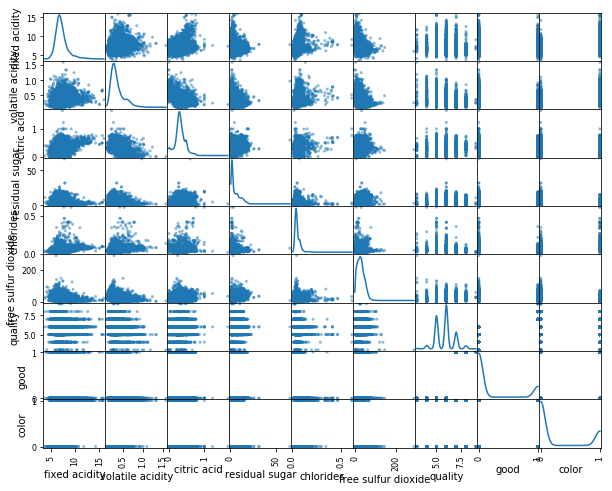

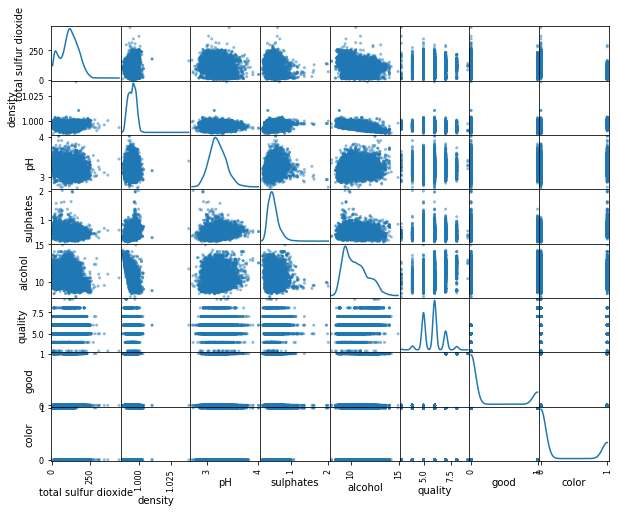

In [13]:
# Do a pairs plot tp see portential relationships
plt.rcParams['figure.figsize'] = [10,8]
sm = pd.plotting.scatter_matrix(numData[['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'quality',
 'good',
 'color']], diagonal = "kde")
plt.show()


plt.rcParams['figure.figsize'] = [10,8]
sm = pd.plotting.scatter_matrix(numData[['total sulfur dioxide',
'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'good',
 'color']], diagonal = "kde")
plt.show()


## Linear Model
already we can see that the model is performing better compared to the models created with the wine review data. However, the best R squared is only about 0.33 which is not ideal.

In [14]:
#The Linear Model Does not perform well at any degree

# construct model object
model = linear_model.LinearRegression() 
model.fit(x_train,y_train) # Fit the model
preds = model.predict(x_test) #Build predictions on the test data

# Look at the actual vs. predicted values:
print(pd.DataFrame({'Actual': y_test, 'Predicted': preds}).head(10))

# Look at the error metrics:
print('Mean Squared Error, Median Absolute Error, R^2, Expected Variance Explained: \n' + 
                                                              str([mean_squared_error(y_test,preds), 
                                                            median_absolute_error(y_test,preds),
                                                           r2_score(y_test,preds), explained_variance_score(y_test,preds)]))

      Actual  Predicted
464        6   5.606385
4086       6   6.189751
294        6   5.690338
917        6   5.930868
648        7   6.017308
2212       5   5.355749
3543       5   4.855879
4156       7   6.473241
4302       5   5.632891
439        5   5.068330
Mean Squared Error, Median Absolute Error, R^2, Expected Variance Explained: 
[0.516106590965004, 0.4641086368446734, 0.3375207817629827, 0.3388282199968877]


In [15]:
# The Quadradic models didn't work any better
degree = [1,2,3]
for i in degree:
    # Create a quadratic variable preprocessor
    quad = PolynomialFeatures(degree = i)
    # Fit and transform the data
    data_x_2 = quad.fit_transform(data_x)

    x_train2,x_test2,y_train2,y_test2 = train_test_split(data_x_2, data_y, test_size = 0.2, random_state = 4)

    #Create, fit, and evaluate quadradic model
    quad_mod = linear_model.LinearRegression()
    quad_mod.fit(x_train2, y_train2)
    preds = quad_mod.predict(x_test2)

    # Look at the actual vs. predicted values:
   # print(pd.DataFrame({'Actual': y_test, 'Predicted': preds}).head(10))

    # Look at the error metrics:
    print('With Degree=',i)
    print('Mean Squared Error, Median Absolute Error, R^2, Expected Variance Explained: \n' + 
                                                              str([mean_squared_error(y_test2,preds), 
                                                            median_absolute_error(y_test2,preds),
                                                           r2_score(y_test2,preds), 
                                                                   explained_variance_score(y_test2,preds)]))

With Degree= 1
Mean Squared Error, Median Absolute Error, R^2, Expected Variance Explained: 
[0.53922185858878, 0.4767268755555705, 0.2871112775531872, 0.2871452581078975]
With Degree= 2
Mean Squared Error, Median Absolute Error, R^2, Expected Variance Explained: 
[0.6191784678924022, 0.46863203381519725, 0.1814030905616294, 0.18151102878944614]
With Degree= 3
Mean Squared Error, Median Absolute Error, R^2, Expected Variance Explained: 
[3.2420101432895194, 0.4494778522348497, -3.286162425347503, -3.283630363442647]


## K-Nearest Neighbors
This model performed much better than the linear regression. I think that the best model is when k = 3 because the accuracy is relatively large and compared to the other k-values that produce a higher accuracy this one is significantly smaller.

In [17]:
#Knn Isn't performing Very Well
from sklearn import neighbors

#Trying KNN Algorithm
ks = [3, 5, 7, 9, 11, 13, 15, 17, 19] #Using odd numbers to make sure it doesn't end in a tie
for k in ks:
    # Create model and fit.
    mod = neighbors.KNeighborsClassifier(n_neighbors = k)
    mod.fit(x_train, y_train)
    
    #Made predictions and look at results.
    y_hat = mod.predict(x_test)
    if accuracy_score(y_test, y_hat) > .3:
        print('---------- EVALUATING MODEL: k = ' + str(k) + '----------')
        print('Accuracy: ' + str(accuracy_score(y_test, y_hat)))
        #print('Precision: ' + str(precision_score(y_test, y_hat)))
        #print('Recall: ' + str(recall_score(y_test, y_hat)))
        #print('F1: ' + str(f1_score(y_test, y_hat)))
        #print('ROC AUC: ' + str(roc_auc_score(y_test, y_hat)))
        print('Confusion Matric: \n' + str(confusion_matrix(y_test, y_hat)))

---------- EVALUATING MODEL: k = 3----------
Accuracy: 0.5480769230769231
Confusion Matric: 
[[  0   0   1   1   0   0   0]
 [  1  11  22   7   0   0   0]
 [  3  13 213  99   8   0   0]
 [  3   9 132 254  48   3   0]
 [  0   1  22  65  83   6   0]
 [  1   1   0  12  11   9   0]
 [  0   0   0   1   0   0   0]]
---------- EVALUATING MODEL: k = 5----------
Accuracy: 0.5384615384615384
Confusion Matric: 
[[  0   0   2   0   0   0   0]
 [  1   4  27   9   0   0   0]
 [  1   4 215 109   7   0   0]
 [  0   3 124 270  48   4   0]
 [  0   0  14  90  65   8   0]
 [  0   0   0  13  15   6   0]
 [  0   0   0   0   1   0   0]]
---------- EVALUATING MODEL: k = 7----------
Accuracy: 0.5259615384615385
Confusion Matric: 
[[  0   0   2   0   0   0   0]
 [  1   3  28   9   0   0   0]
 [  1   3 218 104  10   0   0]
 [  0   3 135 261  47   3   0]
 [  0   0   9 100  62   6   0]
 [  0   0   0  15  16   3   0]
 [  0   0   0   0   1   0   0]]
---------- EVALUATING MODEL: k = 9----------
Accuracy: 0.5394230769

## Naive Bayes
This model performed worse than the Knn model with an accuracy of 0.467.

In [18]:
# Naive Bayes
from sklearn import naive_bayes

nb = naive_bayes.BernoulliNB()
#nb = naive_bayes.GaussianNB()
nb.fit(x_train, y_train)
y_hat = nb.predict(x_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_hat)))
print('Confusion Matric: \n' + str(confusion_matrix(y_test, y_hat)))

Accuracy: 0.4673076923076923
Confusion Matric: 
[[  0   0   2   0   0   0   0]
 [  0   0  20  17   4   0   0]
 [  0   0 214  93  29   0   0]
 [  0   0 170 200  79   0   0]
 [  0   0  24  81  72   0   0]
 [  0   0   5  15  14   0   0]
 [  0   0   0   0   1   0   0]]


## Random Forest
This model performed best overall

In [19]:
#Try Random Forrest. This performed better overall but it wasn't the most reliable model.
from sklearn import ensemble

# Builds a sequence of Random Forest models for different n_est and depth values
n_ests = [5, 10, 50, 80]
depths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Creates a list of tuples containing the n-est and depth values that perform well (n-est, depth)
good_forest = []

for n in n_ests:
    for dp in depths:
        mod = ensemble.RandomForestClassifier(n_estimators = n, max_depth = dp)
        mod.fit(x_train, y_train)
        y_hat = mod.predict(x_test)
        good_forest.append((n, dp))
        if accuracy_score(y_test, y_hat) > .64:
            print('------ Evaluating model: n_estimators =' + str(n) + ', max_depth = ' + str(dp),'------')
            print('Accuracy: ' + str(accuracy_score(y_test, y_hat)))
            print('Confusion Matric: \n' + str(confusion_matrix(y_test, y_hat)))

------ Evaluating model: n_estimators =50, max_depth = 12 ------
Accuracy: 0.6471153846153846
Confusion Matric: 
[[  0   0   1   1   0   0   0]
 [  0   2  28  11   0   0   0]
 [  0   1 239  94   2   0   0]
 [  0   0  78 337  34   0   0]
 [  0   0   4  84  89   0   0]
 [  0   0   0  15  13   6   0]
 [  0   0   0   1   0   0   0]]
------ Evaluating model: n_estimators =80, max_depth = 12 ------
Accuracy: 0.6480769230769231
Confusion Matric: 
[[  0   0   1   1   0   0   0]
 [  0   3  27  11   0   0   0]
 [  0   0 239  95   2   0   0]
 [  0   0  80 341  27   1   0]
 [  0   0   2  91  84   0   0]
 [  0   0   0  13  14   7   0]
 [  0   0   0   1   0   0   0]]


# Testing these results
Random Forest with 50 estimators and a max depth of 12 was the best but that isn't saying much when the accuracy is less than 50%

In [20]:
rf_mod = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 12)
rf_mod.fit(x_train, y_train)
y_hat = rf_mod.predict(x_test1)

print('---------- Evaluating Random Forest Model ----------')
print('Accuracy: ' + str(accuracy_score(y_test1, y_hat)))
print('Confusion Matric: \n' + str(confusion_matrix(y_test1, y_hat)))

---------- Evaluating Random Forest Model ----------
Accuracy: 0.6561538461538462
Confusion Matric: 
[[  0   0   3   2   0   0   0]
 [  0   2  22  17   1   0   0]
 [  0   0 307 130   3   0   0]
 [  0   0 115 435  16   0   0]
 [  0   0   5  97 103   0   0]
 [  0   0   0  22  13   6   0]
 [  0   0   0   1   0   0   0]]


In [21]:
rf_mod = ensemble.RandomForestClassifier(n_estimators = 80, max_depth = 12)
rf_mod.fit(x_train, y_train)
y_hat = rf_mod.predict(x_test1)

print('---------- Evaluating Random Forest Model ----------')
print('Accuracy: ' + str(accuracy_score(y_test1, y_hat)))
print('Confusion Matric: \n' + str(confusion_matrix(y_test1, y_hat)))

---------- Evaluating Random Forest Model ----------
Accuracy: 0.6576923076923077
Confusion Matric: 
[[  0   0   3   2   0   0   0]
 [  0   2  25  14   1   0   0]
 [  0   1 313 121   5   0   0]
 [  0   0 115 428  23   0   0]
 [  0   0   4  95 106   0   0]
 [  0   0   0  22  13   6   0]
 [  0   0   0   1   0   0   0]]
